# Home credit default prediction

Within this notebook, we will focus on building, optimizing and evaluating a model which would allow predicting whether the loan is likely to default or not. It would be used by retail banks to evaluate the default risk. We will use features engineered after the EDA part.

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import lightgbm

from dython.nominal import associations

from statsmodels.stats.proportion import proportions_ztest

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, cross_validate, \
                                    StratifiedKFold, KFold

from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import recall_score, average_precision_score, \
                            precision_recall_curve, precision_score, r2_score, \
                            mean_squared_error, roc_auc_score, f1_score, \
                            classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier, \
                             GradientBoostingRegressor, RandomForestRegressor

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder

from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.linear_model import LinearRegression, SGDRegressor

from sklearn.utils.class_weight import compute_class_weight
from sklearn import set_config

from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures

set_config(transform_output = "pandas")

import optuna
import pickle as pkl
import joblib

from helpers import helpers as h

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Models

The general model building and optimization framework used here are as follows:
* The dataset is divided into training, validation and testing sets. For computationally expensive operations, a subset of the training dataset is used as a proxy of model performance.
* The baseline model performance is checked by using features provided in the training application data file.
* The engineered features are added to the dataset to check if they boost model performance.
* Feature selection procedure included in the pipeline is as follows:
    1. Removing quasi-constant features.
    2. Removing highly correlated features
    3. Training the model of interest and selecting 70 features with the highest importance values. Other features were excluded.
* Pipeline and hyperparameter optimization is performed with the 2 best performing models based on initial f1 and balanced accuracy scores.
* Models are retrained using a full dataset.
* Final model performance is tested on the left out dataset.

### Performance metrics 

In this project, precision seems to be important - we would like to correctly identify those that are likely to experience a default. Lending money to customers that will not pay back the interest rate is not beneficial to our business. On the other hand, by being too conservative, we might end up rejecting perfectly reliable loaners and losing money. Therefore, we will try to keep the balance between the precision and recall scores and evaluate the models based on the f1 score. In addition, we would like to take into account a balanced accuracy score to ensure the balance between sensitivity (ability to determine the default cases correctly) and specificity (ability to determine the non-default cases correctly). Therefore, we will check this metric as well.

## Load and prepare data

We are going to load in 2 datasets prepared in the EDA and feature engineering part. 

First, the dataset with the base features (train_application dataset) will be loaded and prepared for pipelines.

In [2]:
train_base_features = pd.read_pickle("./home_credit_base_features.pkl") 

with open("home_credit_base_feature_lists.pkl", "rb") as f:
    categorical_base_features, numeric_base_features = pkl.load(f) 

In [3]:
y = train_base_features.target
X = train_base_features.drop(['sk_id_curr', 'target'], axis=1)

categorical_base_features = [col for col in 
                             categorical_base_features 
                             if col not in {'sk_id_curr', 'target'}]

subset_size = 0.2

(X_train_base, X_val_base, 
X_test_base, y_train_base,
y_val_base, y_test_base) = h.train_val_test_split(X, y, 0.2, 0.2)

X_train_base_subset, y_train_base_subset \
= h.select_subset(X_train_base, y_train_base, subset_size)

## Multiple model building

We will test a set of models to check the performance.

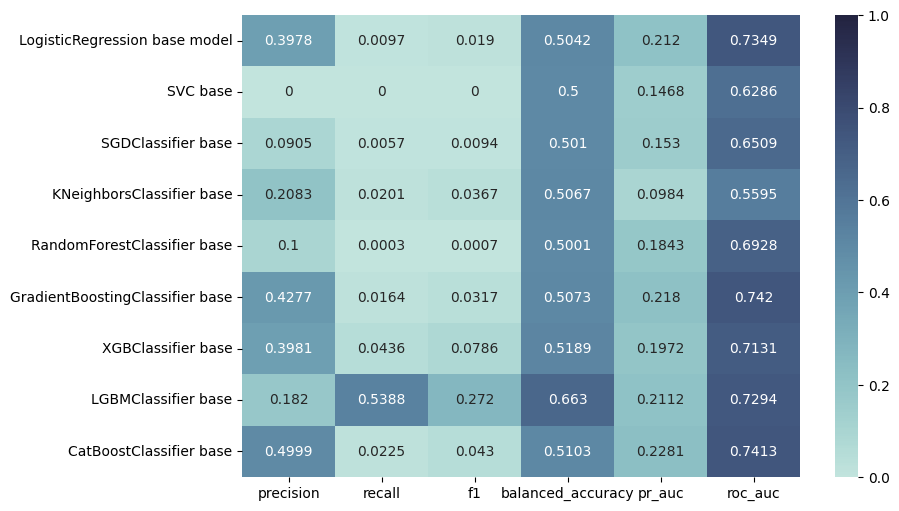

In [4]:
preprocess = h.make_preprocessing_pipeline(X_train_base_subset, 
                                           numeric_base_features, 
                                           categorical_base_features)

classifiers = [
    LogisticRegression(),
    SVC(kernel="linear"),
    SGDClassifier(loss="hinge"),
    KNeighborsClassifier(),
    RandomForestClassifier(n_jobs=-1),
    GradientBoostingClassifier(),
    XGBClassifier(tree_method='gpu_hist'),
    LGBMClassifier(is_unbalance=True),
    CatBoostClassifier(verbose=0)
    ]

score_base_model = h.fit_evaluate_classifiers(preprocess, 
                                             classifiers,
                                             X_train_base_subset, 
                                             y_train_base_subset)

label_clf = [
    'LogisticRegression base model',
    'SVC base',
    "SGDClassifier base",
    'KNeighborsClassifier base',
    'RandomForestClassifier base',
    'GradientBoostingClassifier base',
    'XGBClassifier base',
    'LGBMClassifier base',
    'CatBoostClassifier base']

h.plot_performance(score_base_model, label_clf)

Next, we will load in and prepare the engineered features for modelling.

In [2]:
train_features = pd.read_pickle("./home_credit_features.pkl") 

with open("home_credit_feature_lists.pkl", "rb") as f:
    categorical_features, numeric_features = pkl.load(f)

Since we have created a lot of features, some of them might be redundant. Therefore, we will adapt the pipeline in such a way that it eliminates some features that are quasi-constant and highly correlated.

In [3]:
y = train_features.target
X = train_features.drop(['sk_id_curr', 'target'], axis=1)

(X_train, X_val, 
X_test, y_train,
y_val, y_test) = h.train_val_test_split(X, y, 0.2, 0.2)

X_train_subset = X_train.copy()
y_train_subset = y_train.copy()

subset_size = 0.2

X_train_subset, y_train_subset \
= h.select_subset(X_train, y_train, subset_size)

preprocess_transformer = h.make_preprocessing_pipeline(X_train_subset,
                                                       numeric_features, 
                                                       categorical_features)

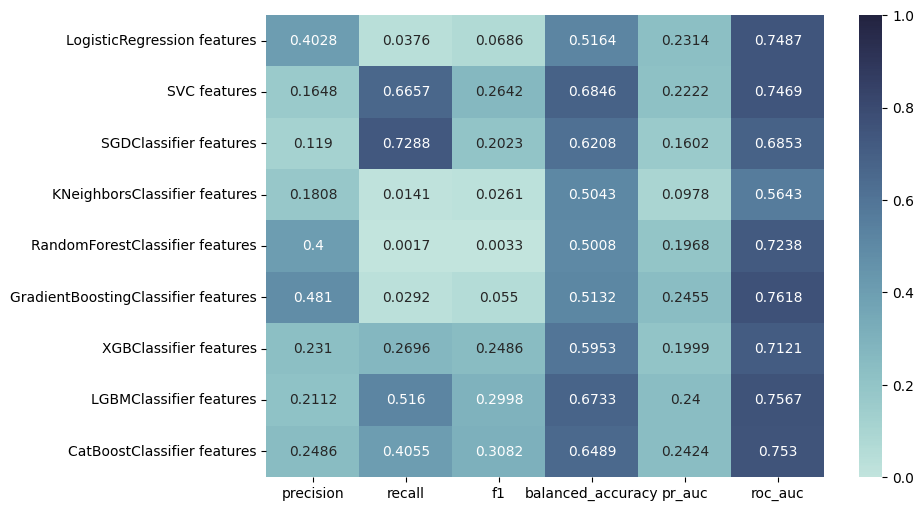

In [7]:
steps = [
    ('preprocess', preprocess_transformer),
    ('constant', DropConstantFeatures(tol=0.99)),
    ('correlated', DropCorrelatedFeatures(variables=None, 
                                          method='pearson', 
                                          threshold=0.9))
    ]

preprocess_features = Pipeline(steps)

classes = np.unique(y_train_subset)
weights = compute_class_weight(class_weight='balanced', 
                               classes=classes,
                               y=y_train_subset)

class_weights = dict(zip(classes, weights))

classifiers = [
    LogisticRegression(),
    SVC(kernel="linear", class_weight="balanced"),
    SGDClassifier(loss="hinge", class_weight="balanced"),
    KNeighborsClassifier(),
    RandomForestClassifier(class_weight="balanced"),
    GradientBoostingClassifier(),
    XGBClassifier(tree_method='gpu_hist', 
                  scale_pos_weight=weights[1]/weights[0]),
    LGBMClassifier(is_unbalance=True),
    CatBoostClassifier(verbose=0, class_weights=class_weights)
    ]

score_drop_features_model \
= h.fit_evaluate_classifiers(preprocess_features, 
                            classifiers,
                            X_train_subset, 
                            y_train_subset)

label_clf = [
    'LogisticRegression features',
    'SVC features',
    "SGDClassifier features",
    'KNeighborsClassifier features',
    'RandomForestClassifier features',
    'GradientBoostingClassifier features',
    'XGBClassifier features',
    'LGBMClassifier features',
    'CatBoostClassifier features']

h.plot_performance(score_drop_features_model, label_clf)

We see that with engineered and selected features, some models perform slightly better. We will choose to optimize the 2 models in which f1 and balanced accuracy mean scores were highest - Catboost Classifier (0.479) and LGBM Classifier (0.487).

## 2 best model optimization

Within this session, we will optimize best-performing models with additional feature selection, pipeline optimization and hyperparameter tuning.

### LGBM Classifier optimization

LGBM Classifier will be optimized. First, we will check which categorical encode works best with this model.

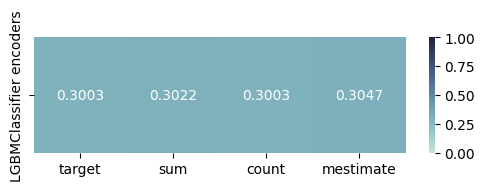

In [8]:
encoders = [
    'target',
    'sum',
    'count',
    'mestimate'
    ]

classifier = [
    LGBMClassifier(is_unbalance=True)
    ]

encoder_dict={}
for encoder in encoders: 
    preprocess = h.make_preprocessing_pipeline(X_train_subset,
                                            numeric_features, 
                                            categorical_features,
                                            encoder)
                                             
    score_enc = h.fit_evaluate_preprocessors(preprocess, 
                                         classifier,
                                         X_train_subset, 
                                         y_train_subset)

    encoder_dict[encoder] = score_enc['f1']

h.plot_performance(encoder_dict, ['LGBMClassifier encoders'], fig_size=(6, 1.5))

The f1 score was highest for the M-probability estimate of the likelihood encoder. We will continue with this one further.

In [9]:
preprocessor = h.make_preprocessing_pipeline(X_train, 
                                            numeric_features, 
                                            categorical_features,
                                            'mestimate')

steps = [
        ('preprocess', preprocessor),
        ('constant', DropConstantFeatures(tol=0.99)),
        ('correlated', DropCorrelatedFeatures(variables=None, 
                                          method='pearson', 
                                          threshold=0.9))
    ]

preprocess_features = Pipeline(steps)

X_train_selected = preprocess_features.fit_transform(X_train, y_train)
X_val_selected = preprocess_features.transform(X_val)
X_test_selected = preprocess_features.transform(X_test)

Next, we will train the initial model on full dataset and select features with highest importance.

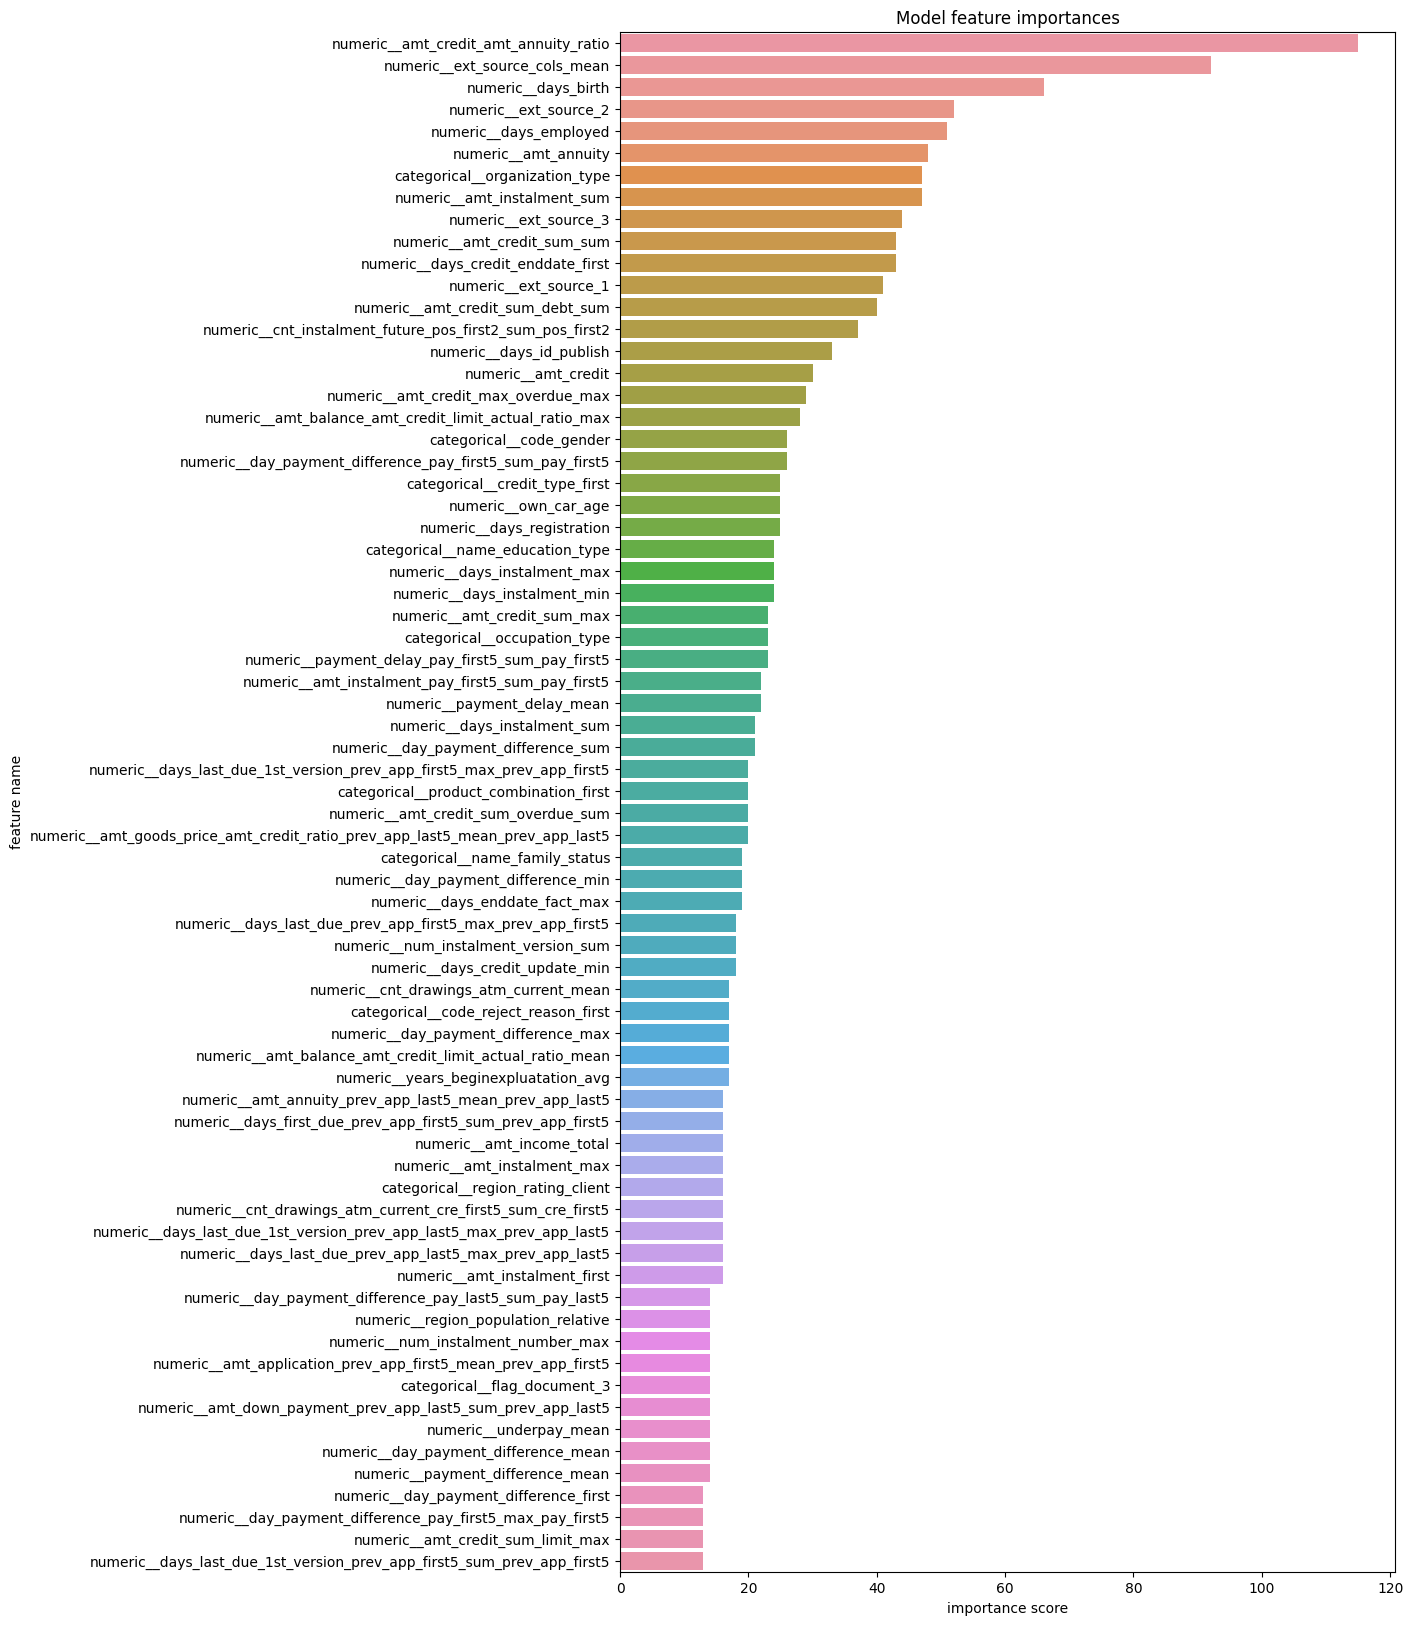

In [10]:
lgbm_clf = LGBMClassifier()
lgbm_clf.fit(X_train_selected, y_train)

col_names_lgbm = h.plot_importance(lgbm_clf, X_train_selected.columns, 70)

The best performing models will be tuned using optuna. We will perform a hyperparameter search with the objective of maximising the f1 score (balanced accuracy was also tried out and gave very similar model outputs). Using optimized parameters we are going to retrain the model on a full training dataset and check the performance using the validation dataset.

In [11]:
X_train_selected_lgbm = X_train_selected[col_names_lgbm.tolist()]
X_val_selected_lgbm = X_val_selected[col_names_lgbm.tolist()]
X_test_selected_lgbm = X_test_selected[col_names_lgbm.tolist()]

X_train_selected_lgbm_subset, \
y_train_subset = h.select_subset(X_train_selected_lgbm, y_train, 0.5)

optimization_metric = "f1"
n_trials = 50
lightgbm_best_params = h.run_optuna_study(X_train_selected_lgbm_subset,
                                         y_train_subset, 
                                         h.objective_lightgbm,
                                         "maximize", optimization_metric, 
                                         n_trials=n_trials)

[I 2023-02-04 18:14:11,183] A new study created in memory with name: no-name-6f5c01f6-43a9-4a2c-8bd7-d652ee456133
[I 2023-02-04 18:15:19,776] Trial 0 finished with value: 0.06698133350948199 and parameters: {'n_estimators': 700, 'lambda_l1': 1.0914243987780369e-06, 'lambda_l2': 2.2244118826203965e-05, 'num_leaves': 188, 'feature_fraction': 0.7241880406207034, 'bagging_fraction': 0.8548623462599723, 'bagging_freq': 10, 'min_child_samples': 89, 'is_unbalance': False}. Best is trial 0 with value: 0.06698133350948199.
[I 2023-02-04 18:17:53,370] Trial 1 finished with value: 0.06439938432761365 and parameters: {'n_estimators': 2400, 'lambda_l1': 1.5436378091444894e-06, 'lambda_l2': 0.0048367489920410536, 'num_leaves': 215, 'feature_fraction': 0.43391290333289334, 'bagging_fraction': 0.5459976150537149, 'bagging_freq': 13, 'min_child_samples': 88, 'is_unbalance': False}. Best is trial 0 with value: 0.06698133350948199.
[I 2023-02-04 18:19:51,970] Trial 2 finished with value: 0.08033569105139

[I 2023-02-04 18:53:55,107] Trial 20 finished with value: 0.09333425411398469 and parameters: {'n_estimators': 2400, 'lambda_l1': 0.0009248936801537025, 'lambda_l2': 0.052250052984019725, 'num_leaves': 251, 'feature_fraction': 0.9928297138975947, 'bagging_fraction': 0.9199958461449933, 'bagging_freq': 12, 'min_child_samples': 59, 'is_unbalance': True}. Best is trial 18 with value: 0.28986818998215874.
[I 2023-02-04 18:54:22,073] Trial 21 finished with value: 0.2822569970378169 and parameters: {'n_estimators': 400, 'lambda_l1': 0.03398479896846188, 'lambda_l2': 0.8921032792554056, 'num_leaves': 82, 'feature_fraction': 0.8772485919439151, 'bagging_fraction': 0.7967592825499126, 'bagging_freq': 9, 'min_child_samples': 77, 'is_unbalance': True}. Best is trial 18 with value: 0.28986818998215874.
[I 2023-02-04 18:54:54,060] Trial 22 finished with value: 0.26218487222195097 and parameters: {'n_estimators': 500, 'lambda_l1': 0.05685564631200258, 'lambda_l2': 1.2195215783309479, 'num_leaves': 8

[I 2023-02-04 19:10:44,677] Trial 40 finished with value: 0.28051477904174427 and parameters: {'n_estimators': 800, 'lambda_l1': 3.6303006100522195e-05, 'lambda_l2': 0.002284573885004645, 'num_leaves': 39, 'feature_fraction': 0.754544364325213, 'bagging_fraction': 0.851724866223859, 'bagging_freq': 11, 'min_child_samples': 72, 'is_unbalance': True}. Best is trial 33 with value: 0.3054111962759646.
[I 2023-02-04 19:11:11,242] Trial 41 finished with value: 0.30636042859978774 and parameters: {'n_estimators': 1100, 'lambda_l1': 0.00026489729964966174, 'lambda_l2': 0.008280831132737218, 'num_leaves': 17, 'feature_fraction': 0.8084211980784339, 'bagging_fraction': 0.7075332484040529, 'bagging_freq': 9, 'min_child_samples': 83, 'is_unbalance': True}. Best is trial 41 with value: 0.30636042859978774.
[I 2023-02-04 19:11:40,691] Trial 42 finished with value: 0.28983339665616514 and parameters: {'n_estimators': 1100, 'lambda_l1': 0.00022296513898730093, 'lambda_l2': 0.023978457203508198, 'num_l

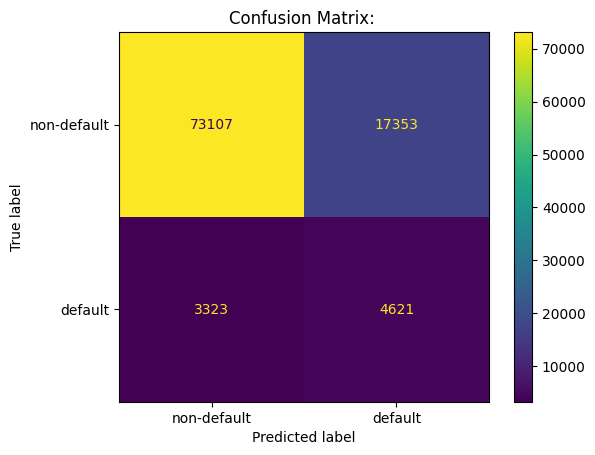

              precision    recall  f1-score   support

 non-default       0.96      0.81      0.88     90460
     default       0.21      0.58      0.31      7944

    accuracy                           0.79     98404
   macro avg       0.58      0.69      0.59     98404
weighted avg       0.90      0.79      0.83     98404



In [12]:
lightgbm_best_params['n_jobs'] = -1
lgbm_clf = LGBMClassifier(**lightgbm_best_params)
lgbm_clf.fit(X_train_selected_lgbm, y_train)

y_val_predicted = lgbm_clf.predict(X_val_selected_lgbm)
lgbm_clf_score = h.evaluate_model(lgbm_clf, y_val, y_val_predicted)

The model returned 0.58 recall and 0.21 precision on the validation dataset. We will also check precision-recall and ROC-AUC curves.

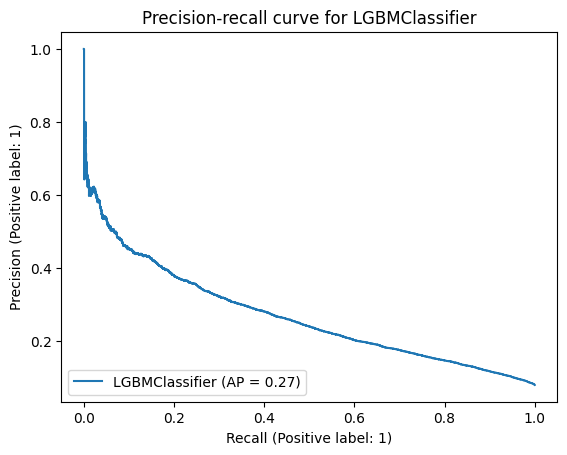

In [13]:
PrecisionRecallDisplay.from_estimator(lgbm_clf, X_val_selected_lgbm, y_val)
plt.title('Precision-recall curve for LGBMClassifier');

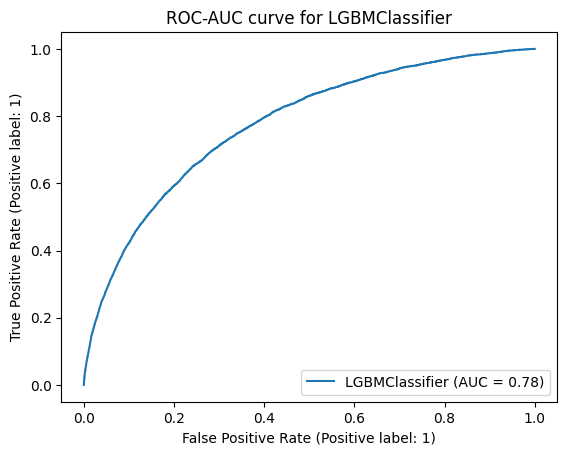

In [14]:
RocCurveDisplay.from_estimator(lgbm_clf, X_val_selected_lgbm, y_val)
plt.title('ROC-AUC curve for LGBMClassifier');

We got 0.28 and 0.78 values respectively.

### CatBoost Classifier optimization

Similarly, we will optimize the CatBoost Classifier. Investigating different categorical encoders:

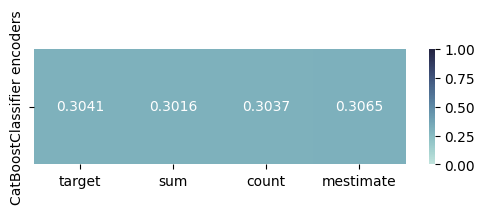

In [16]:
X_train_subset, y_train_subset \
= h.select_subset(X_train, y_train, subset_size)

classes = np.unique(y_train_subset)
weights = compute_class_weight(class_weight='balanced', 
                               classes=classes,
                               y=y_train_subset)

class_weights = dict(zip(classes, weights))

encoders = [
    'target',
    'sum',
    'count',
    'mestimate'
    ]

classifier = [
    CatBoostClassifier(verbose=0, class_weights=class_weights)
    ]

encoder_dict={}
for encoder in encoders: 
    preprocess = h.make_preprocessing_pipeline(X_train_subset,
                                            numeric_features, 
                                            categorical_features,
                                            encoder)
                                             
    score_enc = h.fit_evaluate_preprocessors(preprocess, 
                                          classifier,
                                          X_train_subset, 
                                          y_train_subset)

    encoder_dict[encoder] = score_enc['f1']

h.plot_performance(encoder_dict, ['CatBoostClassifier encoders'], fig_size=(6, 1.5))

Seems that the intial (ordinal) encoder resulted in best f1 score (0.3082). Therefore, we will proceed with it.

In [4]:
preprocessor = h.make_preprocessing_pipeline(X_train, 
                                            numeric_features, 
                                            categorical_features,
                                            'ordinal')

steps = [
        ('preprocess', preprocessor),
        ('constant', DropConstantFeatures(tol=0.99)),
        ('correlated', DropCorrelatedFeatures(variables=None, 
                                          method='pearson', 
                                          threshold=0.9))
    ]

preprocess_features = Pipeline(steps)

X_train_selected = preprocess_features.fit_transform(X_train, y_train)
X_val_selected = preprocess_features.transform(X_val)
X_test_selected = preprocess_features.transform(X_test)

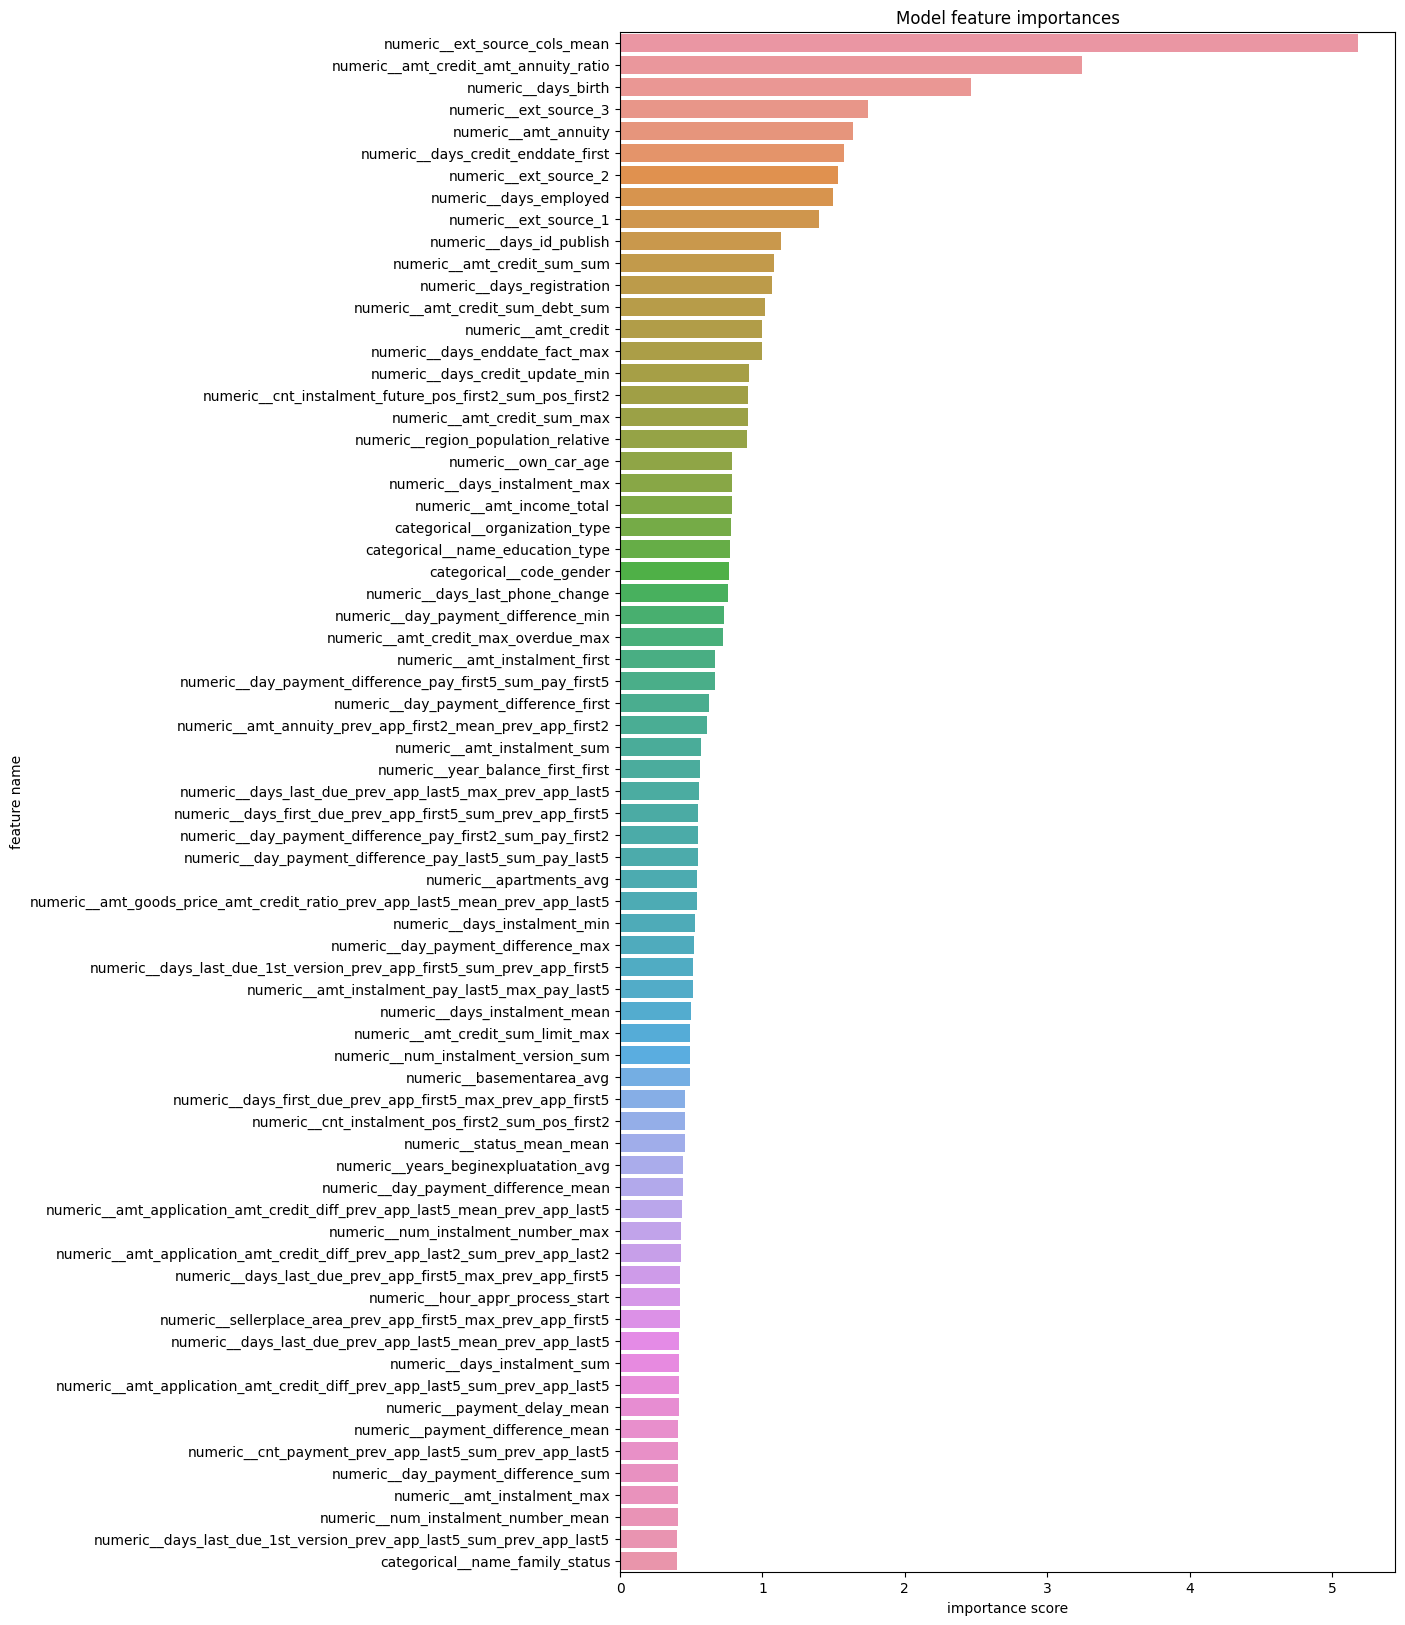

In [5]:
catboost_clf = CatBoostClassifier(verbose=0, class_weights=class_weights)
catboost_clf.fit(X_train_selected, y_train)

col_names_catboost = h.plot_importance(catboost_clf, X_train_selected.columns)

Optimization with optuna.

In [6]:
X_train_selected_catboost = X_train_selected[col_names_catboost.tolist()]
X_val_selected_catboost = X_val_selected[col_names_catboost.tolist()]
X_test_selected_catboost = X_test_selected[col_names_catboost.tolist()]

X_train_selected_catboost_subset, \
y_train_subset = h.select_subset(X_train_selected_catboost, y_train, 0.5)

catboost_best_params = h.run_optuna_study(X_train_selected_catboost_subset,
                                         y_train_subset, 
                                         h.objective_catboost,
                                         "maximize", optimization_metric, 
                                         n_trials=n_trials)

[I 2023-02-04 23:01:30,724] A new study created in memory with name: no-name-b813c927-dc0e-45d6-8d85-b0d76072226b
[I 2023-02-04 23:03:08,424] Trial 0 finished with value: 0.27883735375793195 and parameters: {'n_estimators': 2800, 'learning_rate': 0.016120653032216728, 'colsample_bylevel': 0.07638182918254963, 'depth': 4, 'l2_leaf_reg': 3.3683647319439114, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.16740127854430784}. Best is trial 0 with value: 0.27883735375793195.
[I 2023-02-04 23:18:18,200] Trial 1 finished with value: 0.26712298977449206 and parameters: {'n_estimators': 4200, 'learning_rate': 0.00020069741428904023, 'colsample_bylevel': 0.032016384381339864, 'depth': 8, 'l2_leaf_reg': 1.482487116344518, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.357648593217164}. Best is trial 0 with value: 0.27883735375793195.
[I 2023-02-04 23:47:35,906] Trial 2 finished with value: 0.27483102563763856 and parameters: {'n_estimato

[I 2023-02-05 00:47:59,319] Trial 22 finished with value: 0.30975295863060137 and parameters: {'n_estimators': 2400, 'learning_rate': 0.01223464405884039, 'colsample_bylevel': 0.0439115966509983, 'depth': 9, 'l2_leaf_reg': 4.570873643970208, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 19 with value: 0.3114458324845043.
[I 2023-02-05 00:49:35,329] Trial 23 finished with value: 0.29794704096939 and parameters: {'n_estimators': 1500, 'learning_rate': 0.010753267641122373, 'colsample_bylevel': 0.043874442874227565, 'depth': 9, 'l2_leaf_reg': 4.498957602567925, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 19 with value: 0.3114458324845043.
[I 2023-02-05 00:52:09,883] Trial 24 finished with value: 0.28899971457543544 and parameters: {'n_estimators': 2500, 'learning_rate': 0.004402250876595298, 'colsample_bylevel': 0.04353546590988676, 'depth': 9, 'l2_leaf_reg': 4.605856687612221, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 19 w

[I 2023-02-05 03:27:31,152] Trial 45 finished with value: 0.19556560090912029 and parameters: {'n_estimators': 4100, 'learning_rate': 0.022919492570751158, 'colsample_bylevel': 0.05728522338969722, 'depth': 10, 'l2_leaf_reg': 5.237848525414703, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9388916492121788}. Best is trial 32 with value: 0.313688682254034.
[I 2023-02-05 03:32:19,097] Trial 46 finished with value: 0.29880235146237755 and parameters: {'n_estimators': 3700, 'learning_rate': 0.015098574805868747, 'colsample_bylevel': 0.05298946840542052, 'depth': 9, 'l2_leaf_reg': 3.874121514661431, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 32 with value: 0.313688682254034.
[I 2023-02-05 03:34:47,685] Trial 47 finished with value: 0.28714540541297584 and parameters: {'n_estimators': 3100, 'learning_rate': 0.005490892084831962, 'colsample_bylevel': 0.04607801157109184, 'depth': 7, 'l2_leaf_reg': 4.249282000344601, 'boosting_type': 'Plain', 'b

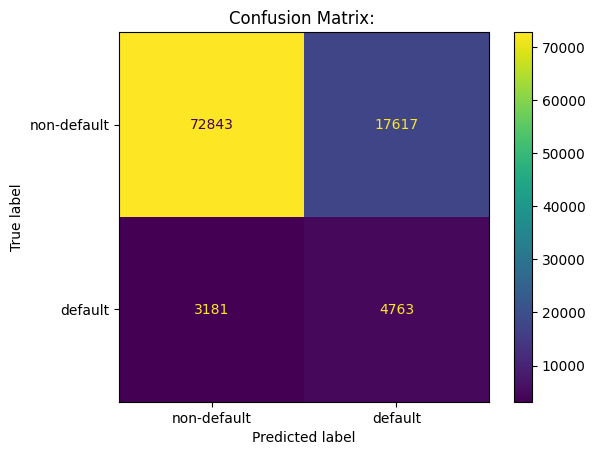

              precision    recall  f1-score   support

 non-default       0.96      0.81      0.88     90460
     default       0.21      0.60      0.31      7944

    accuracy                           0.79     98404
   macro avg       0.59      0.70      0.59     98404
weighted avg       0.90      0.79      0.83     98404



In [7]:
catboost_best_params['class_weights'] = class_weights
catboost_best_params['verbose'] = 0

catboost_clf = CatBoostClassifier(**catboost_best_params)
catboost_clf.fit(X_train_selected_catboost, y_train)

y_val_predicted = catboost_clf.predict(X_val_selected_catboost)
catboost_clf_score = h.evaluate_model(catboost_clf, 
                                      y_val, 
                                      y_val_predicted)

This model gave identical f1 and precision scores, but higher recall for the default class. It seems to be performing better than the previous one.

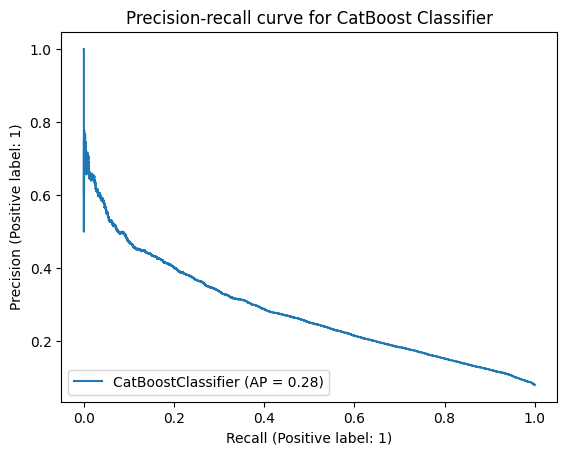

In [8]:
PrecisionRecallDisplay.from_estimator(catboost_clf,
                                      X_val_selected_catboost,
                                      y_val)

plt.title('Precision-recall curve for CatBoost Classifier');

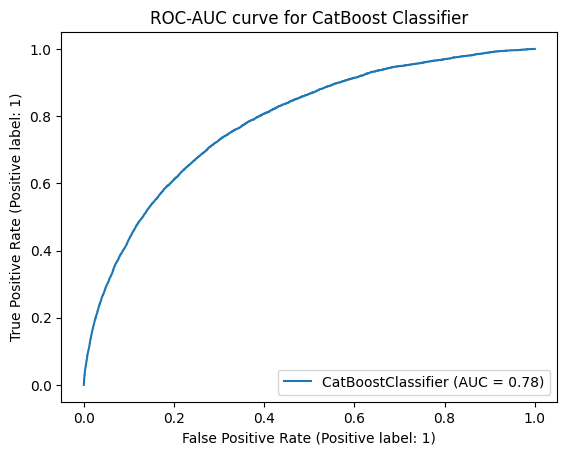

In [9]:
RocCurveDisplay.from_estimator(catboost_clf, 
                               X_val_selected_catboost, y_val)

plt.title('ROC-AUC curve for CatBoost Classifier');

The CatBoost model gave the same ROC AUC, but a slightly higher AP ROC score in comparison to LGBM Classifier. Catboost will be selected as the final model.

We got high precision and recall values for the non-default class, but the default are much lower.

### CatBoost Classifier performance on test data

The model hyperparameters are optimized. The model will be retrained again including the training and validation dataset.

In [47]:
X_train_val_selected = pd.concat([X_train_selected_catboost,
                                  X_val_selected_catboost])

y_train_val = pd.concat([y_train, y_val])

catboost_clf.fit(X_train_val_selected, y_train_val)

The final model will be saved for model deployment.

In [10]:
joblib.dump(catboost_clf, 'credit_model_catboost.pkl')

['credit_model_catboost.pkl']

We will evaluate the models' performance on the test set and consider it as a final score.

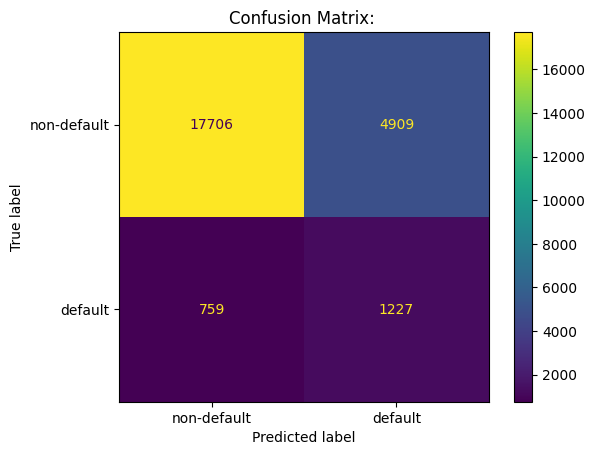

              precision    recall  f1-score   support

 non-default       0.96      0.78      0.86     22615
     default       0.20      0.62      0.30      1986

    accuracy                           0.77     24601
   macro avg       0.58      0.70      0.58     24601
weighted avg       0.90      0.77      0.82     24601



In [216]:
threshold = 0.5

predicted_default_probability = catboost_clf.predict_proba \
                                (X_test_selected_catboost)[:, 1]

y_test_predicted = (predicted_default_probability \
                    >= threshold).astype(int)

catboost_clf_best_score_test = h.evaluate_model(catboost_clf, y_test, y_test_predicted)

The final test returned very similar scores to validation: 0.3 f1, 0.2 precision and 0.62 recall scores for the default class. Recall and f1 score for the non-default class are slightly lower, but we can accept that because we prioritise the default class (more harmful for business).

## Model evaluation

Next, we will consider the built model's usefulness to identify loan defaulters. Usually, banks have a rule (calculation) to derive a threshold determining which loan amount the loaner is capable of paying back. According to this rule, your mortgage payment shouldn't be more than 28% of your monthly pre-tax income and 36% of your total debt. We do not have a debt-to-income ratio in this data, but we can calculate a similar metric - credit amount to income total amount.

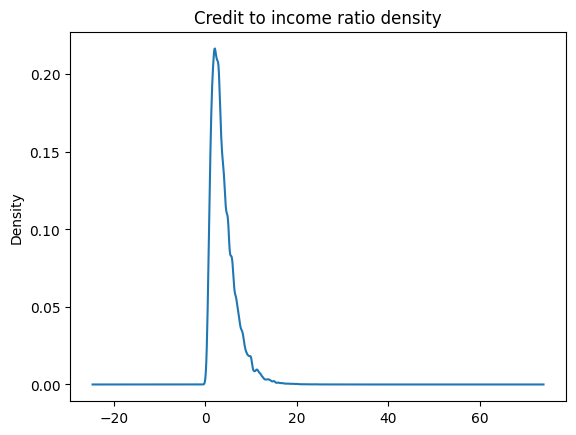

In [12]:
(X_train.amt_credit/X_train.amt_income_total).plot(kind='kde')
plt.title('Credit to income ratio density');

Looking at the training credit-to-income ratio we see that most of the values fall between 0-10. Knowing that 8% of the loans default, as a rule of thumb, we will guess that all those that pay debt above this ratio will default. 

In [13]:
X_test['amt_credit_amt_income_ratio'] \
= X_test.amt_credit/X_test.amt_income_total

X_test['simple_rule'] = 0
rule = X_test['amt_credit_amt_income_ratio'] >= 10
X_test.loc[rule, 'simple_rule'] = 1

Let's see how many defaults we would have guessed right with this simple rule.

In [14]:
crosstab = pd.crosstab(X_test.simple_rule, 
                       y_test, margins=True)
crosstab

target,0,1,All
simple_rule,,,
0,21833,1941,23774
1,782,45,827
All,22615,1986,24601


45 individuals would have been identified correctly. Now, let's perform the proportion z test to see if our model performance is better that the simple rule we came up her with.

In [15]:
n_correct = 1227
count = np.array([crosstab[1][1], n_correct])
nobs = np.array([1986, 1986])
stat, pval = proportions_ztest(count, nobs)
pval

0.0

The P-value is below 0.05 which indicates that our model is able to capture more default cases than a simple rule. Our model provides a significant advantage compared to a simple calculation to identify those that will default.

### Usability of the model

The created model could also be useful for adjusting interest rates based on the predicted loan probability. Currently, the loan rates are ranging from 4 to 5 % (in the Netherlands). Instead of rejecting the loans that we think will default, we will increase the interest rate up to 5 % for those that were predicted to default. 1 additional per cent will be scaled based on default class probability. It will only be added to the class predicted as default - we would not like to repel credible loaners with high-interest rates and keep the competitive advantage.

In [448]:
fixed_interest = 0.04
X_test['fixed_interest'] = X_test.amt_credit * fixed_interest

plus_interest = 0.01 * y_test_predicted * predicted_default_probability
X_test['plus_interest'] = X_test.amt_credit * plus_interest
X_test['adjusted_interest'] = X_test['plus_interest'] + X_test['fixed_interest']

Now we will calculate the difference between how much money would have been earned with fixed and adjusted interest rates. We will exclude defaulted loans assuming that 0 interest rates have been paid for those.

In [451]:
non_default_flag = y_test !=1

round(sum(X_test[non_default_flag].adjusted_interest) - sum(X_test[non_default_flag].fixed_interest), 2)

16937689.03

We see that with the adjusted interest rate for likely-to-default loaners we would have earned more money than by having fixed rate for everybody even if some of these loans defaulted.

## Model deployment

Model was deployed on google cloud using App Engine with streamlit: [loans app](https://loans-app-371713.nn.r.appspot.com/)

# Conclusions

* Here, we built a model with a purpose of identifying which loans will default. Overall goal is to create a tool for better default risk identification to retail banks.
* We built models with engineered features and selected 2 best performing ones for further optimization.
* Models were optimized by selecting suitable encoders, 70 most important features adn perfroming hyperparameter tuning.
* The final model was CatBooost Classifier which resulted in **0.2 precision** and **0.62 recall** of the default class prediction.
* It was demonstrated that by usingthe model to adjust interest rates we could monetize to model to bank's advantage.
* A functional app predicting default was deployed.

## Improvements

* The associations of the engineered features and target variable could have been explored more thoroughly.
* While feature selection from model was performed here, there are multiple other methods (recursive selection, filtering, wrapping) that could be used to optimize the model.
* Seems like the model experienced a bit of over fitting. This could be related ot the fact that model was optimized using a subset of data due to the computational power limitations. It could be investigated more (using more powerful computation stations).